In [84]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import pytensor
import pytensor.tensor as pt
import scipy as sp
import scipy.stats as st
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pymc.variational.callbacks import CheckParametersConvergence
from patsy import bs, dmatrix
import matplotlib.dates as mdates
import bambi as bm

# Load in the data

In [85]:
data = pd.read_csv("/Users/stephenkullman/Desktop/School of Data Science/DS 6040/Bayes Project Data/student_math_clean.csv")

In [86]:
data.head()

,student_id,school,sex,age,address_type,family_size,parent_status,mother_education,father_education,mother_job,...,family_relationship,free_time,social,weekday_alcohol,weekend_alcohol,health,absences,grade_1,grade_2,final_grade
0,1,GP,F,18,Urban,Greater than 3,Apart,higher education,higher education,at_home,...,4,3,4,1,1,3,6,5,6,6
1,2,GP,F,17,Urban,Greater than 3,Living together,primary education (4th grade),primary education (4th grade),at_home,...,5,3,3,1,1,3,4,5,5,6
2,3,GP,F,15,Urban,Less than or equal to 3,Living together,primary education (4th grade),primary education (4th grade),at_home,...,4,3,2,2,3,3,10,7,8,10
3,4,GP,F,15,Urban,Greater than 3,Living together,higher education,5th to 9th grade,health,...,3,2,2,1,1,5,2,15,14,15
4,5,GP,F,16,Urban,Greater than 3,Living together,secondary education,secondary education,other,...,4,3,2,1,2,5,4,6,10,10


In [92]:
data.columns

Index(['student_id', 'school', 'sex', 'age', 'address_type', 'family_size',
       'parent_status', 'mother_education', 'father_education', 'mother_job',
       'father_job', 'school_choice_reason', 'guardian', 'travel_time',
       'study_time', 'class_failures', 'school_support', 'family_support',
       'extra_paid_classes', 'activities', 'nursery_school', 'higher_ed',
       'internet_access', 'romantic_relationship', 'family_relationship',
       'free_time', 'social', 'weekday_alcohol', 'weekend_alcohol', 'health',
       'absences', 'grade_1', 'grade_2', 'final_grade'],
      dtype='object')

# Exploratory Data Analysis

In [99]:
data.dtypes

student_id                int64
school                   object
sex                      object
age                       int64
address_type             object
family_size              object
parent_status            object
mother_education         object
father_education         object
mother_job               object
father_job               object
school_choice_reason     object
guardian                 object
travel_time              object
study_time               object
class_failures            int64
school_support           object
family_support           object
extra_paid_classes       object
activities               object
nursery_school           object
higher_ed                object
internet_access          object
romantic_relationship    object
family_relationship       int64
free_time                 int64
social                    int64
weekday_alcohol           int64
weekend_alcohol           int64
health                    int64
absences                  int64
grade_1 

In [183]:
data.isna().sum()

student_id               0
school                   0
sex                      0
age                      0
address_type             0
family_size              0
parent_status            0
mother_education         0
father_education         0
mother_job               0
father_job               0
school_choice_reason     0
guardian                 0
travel_time              0
study_time               0
class_failures           0
school_support           0
family_support           0
extra_paid_classes       0
activities               0
nursery_school           0
higher_ed                0
internet_access          0
romantic_relationship    0
family_relationship      0
free_time                0
social                   0
weekday_alcohol          0
weekend_alcohol          0
health                   0
absences                 0
grade_1                  0
grade_2                  0
final_grade              0
dtype: int64

Select only the columns that have integer values to look at correlations

In [100]:
int_columns = data.select_dtypes(include=np.number).columns.to_list()

In [101]:
int_columns

['student_id',
 'age',
 'class_failures',
 'family_relationship',
 'free_time',
 'social',
 'weekday_alcohol',
 'weekend_alcohol',
 'health',
 'absences',
 'grade_1',
 'grade_2',
 'final_grade']

In [102]:
corr_df = data[int_columns]
corr_df.corr()

,student_id,age,class_failures,family_relationship,free_time,social,weekday_alcohol,weekend_alcohol,health,absences,grade_1,grade_2,final_grade
student_id,1.000000,0.758057,0.026426,-0.016190,0.003895,0.068811,0.086302,0.095454,-0.088902,0.065966,0.046963,-0.053344,-0.099991
age,0.758057,1.000000,0.243665,0.053940,0.016434,0.126964,0.131125,0.117276,-0.062187,0.175230,-0.064081,-0.143474,-0.161579
class_failures,0.026426,0.243665,1.000000,-0.044337,0.091987,0.124561,0.136047,0.141962,0.065827,0.063726,-0.354718,-0.355896,-0.360415
family_relationship,-0.016190,0.053940,-0.044337,1.000000,0.150701,0.064568,-0.077594,-0.113397,0.094056,-0.044354,0.022168,-0.018281,0.051363
free_time,0.003895,0.016434,0.091987,0.150701,1.000000,0.285019,0.209001,0.147822,0.075733,-0.058078,0.012613,-0.013777,0.011307
social,0.068811,0.126964,0.124561,0.064568,0.285019,1.000000,0.266994,0.420386,-0.009577,0.044302,-0.149104,-0.162250,-0.132791
weekday_alcohol,0.086302,0.131125,0.136047,-0.077594,0.209001,0.266994,1.000000,0.647544,0.077180,0.111908,-0.094159,-0.064120,-0.054660
weekend_alcohol,0.095454,0.117276,0.141962,-0.113397,0.147822,0.420386,0.647544,1.000000,0.092476,0.136291,-0.126179,-0.084927,-0.051939
health,-0.088902,-0.062187,0.065827,0.094056,0.075733,-0.009577,0.077180,0.092476,1.000000,-0.029937,-0.073172,-0.097720,-0.061335
absences,0.065966,0.175230,0.063726,-0.044354,-0.058078,0.044302,0.111908,0.136291,-0.029937,1.000000,-0.031003,-0.031777,0.034247


<Axes: >

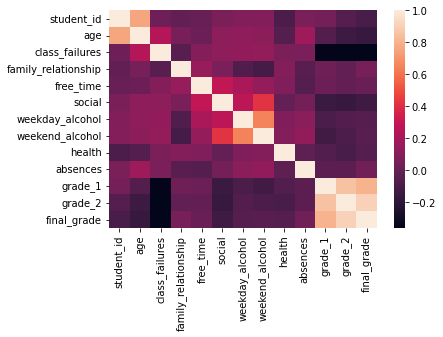

In [103]:
sns.heatmap(corr_df.corr())

As expected, the highly correlated variables are the grades. Not unusual

Let's do the same thing with the categorical variables

In [107]:
cat_columns = data.select_dtypes(include='object').columns.to_list()


In [110]:
for col in cat_columns:
    print(data[col].value_counts())
    print('\n')

school
GP    349
MS     46
Name: count, dtype: int64


sex
F    208
M    187
Name: count, dtype: int64


address_type
Urban    307
Rural     88
Name: count, dtype: int64


family_size
Greater than 3             281
Less than or equal to 3    114
Name: count, dtype: int64


parent_status
Living together    354
Apart               41
Name: count, dtype: int64


mother_education
higher education                 131
5th to 9th grade                 103
secondary education               99
primary education (4th grade)     59
none                               3
Name: count, dtype: int64


father_education
5th to 9th grade                 115
secondary education              100
higher education                  96
primary education (4th grade)     82
none                               2
Name: count, dtype: int64


mother_job
other       141
services    103
at_home      59
teacher      58
health       34
Name: count, dtype: int64


father_job
other       217
services    111
teacher      29


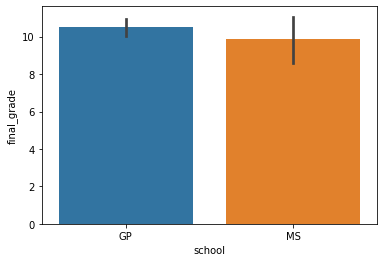

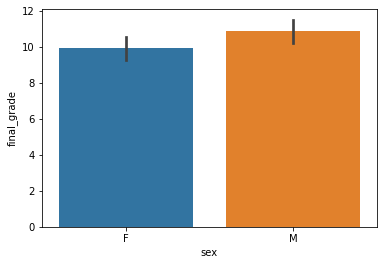

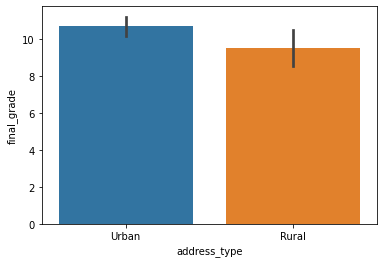

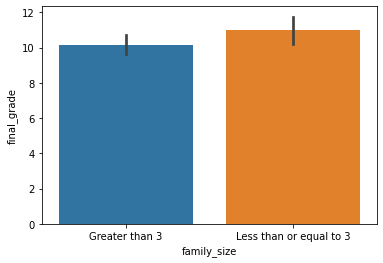

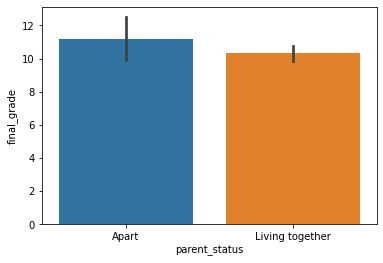

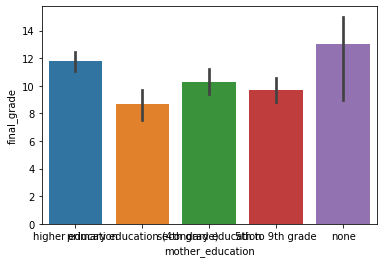

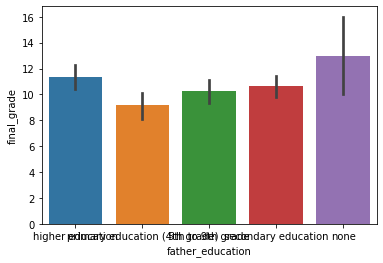

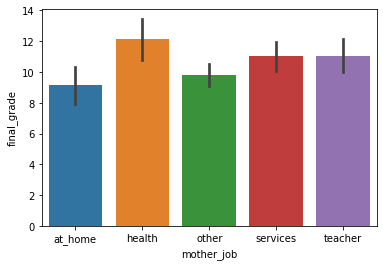

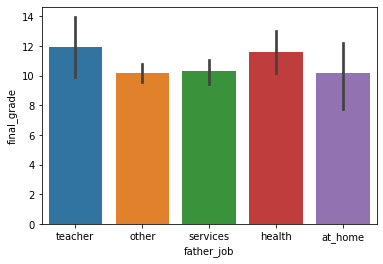

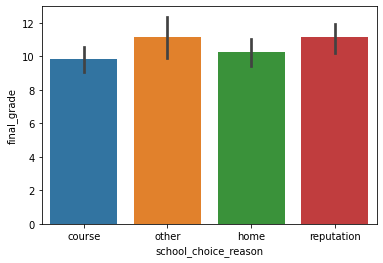

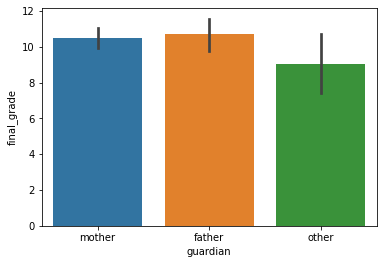

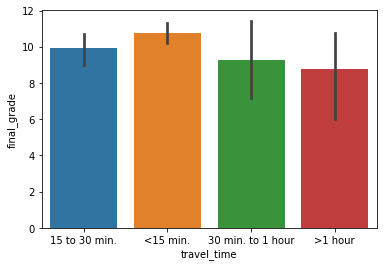

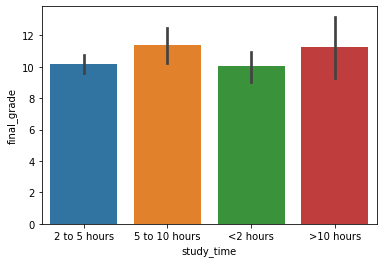

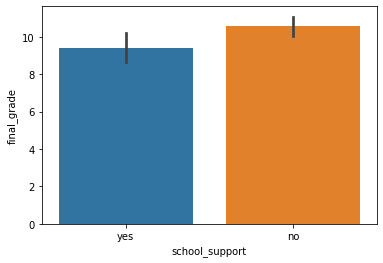

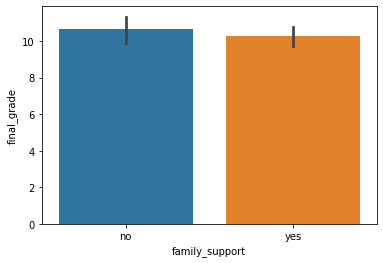

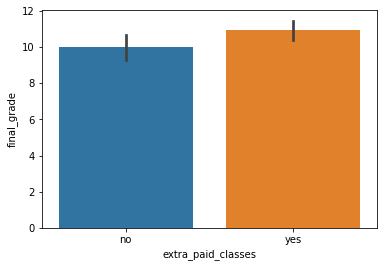

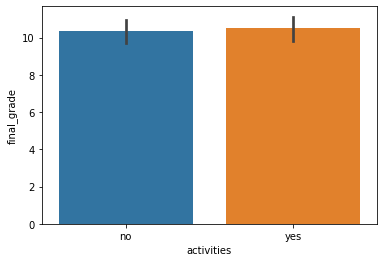

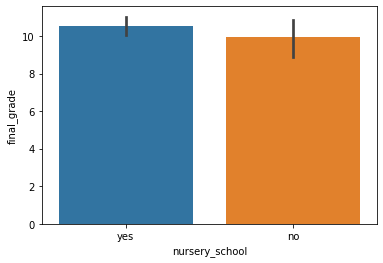

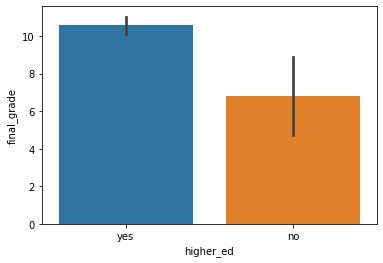

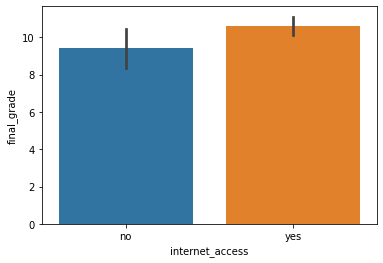

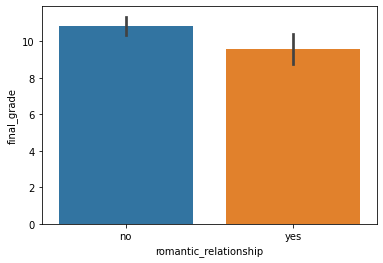

In [115]:
for col in cat_columns:
    sns.barplot(data, x = data[col], y= data['final_grade'])
    plt.show()

# Recoding Yes/No Variables

In [166]:
clean = data.copy(deep=True)

In [168]:
replace_map = {'school_support': {'yes':1,'no': 0},
               'family_support': {'yes':1,'no': 0},
               'extra_paid_classes': {'yes':1,'no': 0},
               'activities': {'yes':1,'no': 0},
               'nursery_school': {'yes':1,'no': 0},
               'higher_ed': {'yes':1,'no': 0},
               'internet_access': {'yes':1,'no': 0},
               'romantic_relationship': {'yes':1,'no': 0}}

In [170]:
clean = clean.replace(replace_map)

In [173]:
clean.dtypes

student_id                int64
school                   object
sex                      object
age                       int64
address_type             object
family_size              object
parent_status            object
mother_education         object
father_education         object
mother_job               object
father_job               object
school_choice_reason     object
guardian                 object
travel_time              object
study_time               object
class_failures            int64
school_support            int64
family_support            int64
extra_paid_classes        int64
activities                int64
nursery_school            int64
higher_ed                 int64
internet_access           int64
romantic_relationship     int64
family_relationship       int64
free_time                 int64
social                    int64
weekday_alcohol           int64
weekend_alcohol           int64
health                    int64
absences                  int64
grade_1 

## Bayesian T-Test on Internet Access

In [174]:
test_df = clean[['internet_access','final_grade']]

In [175]:
test_df.head()

,internet_access,final_grade
0,0,6
1,1,6
2,1,10
3,1,15
4,0,10


In [176]:
summary_stats = (data.loc[:, ["internet_access", "final_grade"]]
                         .groupby("internet_access")
                         .agg(["mean", "std", "count"]))
summary_stats


final_grade                
                       mean       std count
internet_access                            
no                 9.409091  4.485797    66
yes               10.617021  4.580494   329

In [177]:
y0 = test_df.loc[test_df["internet_access"]==0]['final_grade']
y1 = test_df.loc[test_df["internet_access"]==1]["final_grade"]

mu_prior = test_df.final_grade.mean()
std_prior = test_df.final_grade.std() * 2

sigma_low = 1
sigma_high = 100

In [178]:
with pm.Model() as t_test:
    noAccess_mean = pm.Normal("noAccess_mean", mu=mu_prior, sigma=std_prior)
    yesAccess_mean = pm.Normal("yesAccess_mean", mu=mu_prior, sigma=std_prior)
    noAccess_std = pm.Uniform("noAccess_std", lower=sigma_low, upper=sigma_high)
    yesAccess_std = pm.Uniform("yesAccess_std", lower=sigma_low, upper=sigma_high)
    nu = pm.Exponential("nu", 1/29)

    noAccess = pm.StudentT("noAccess", nu=nu, mu=noAccess_mean, sigma=noAccess_std, observed=y0)
    yesAccess = pm.StudentT("yesAccess", nu=nu, mu=yesAccess_mean, sigma=yesAccess_std, observed=y1)
    diff_of_means = pm.Deterministic("difference of means", noAccess_mean - yesAccess_mean)
    diff_of_stds = pm.Deterministic("difference of stds", noAccess_std - yesAccess_std)
    effect_size = pm.Deterministic(
        "effect size", diff_of_means / np.sqrt((noAccess_std ** 2 + yesAccess_std ** 2) / 2)
    )


    internet_trace=pm.sample(random_seed = 1234, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noAccess_mean, yesAccess_mean, noAccess_std, yesAccess_std, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([[<Axes: title={'center': 'noAccess_mean'}>,
        <Axes: title={'center': 'noAccess_mean'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'yesAccess_mean'}>,
        <Axes: title={'center': 'yesAccess_mean'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'noAccess_std'}>,
        <Axes: title={'center': 'noAccess_std'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'yesAccess_std'}>,
        <Axes: title={'center': 'yesAccess_std'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'nu'}>,
        <Axes: title={'center': 'nu'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'difference of means'}>,
        <Axes: title={'center': 'difference of means'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'difference of stds'}>,
        <Axes: title={'center': 'difference of stds'}, xlabel='Rank (all

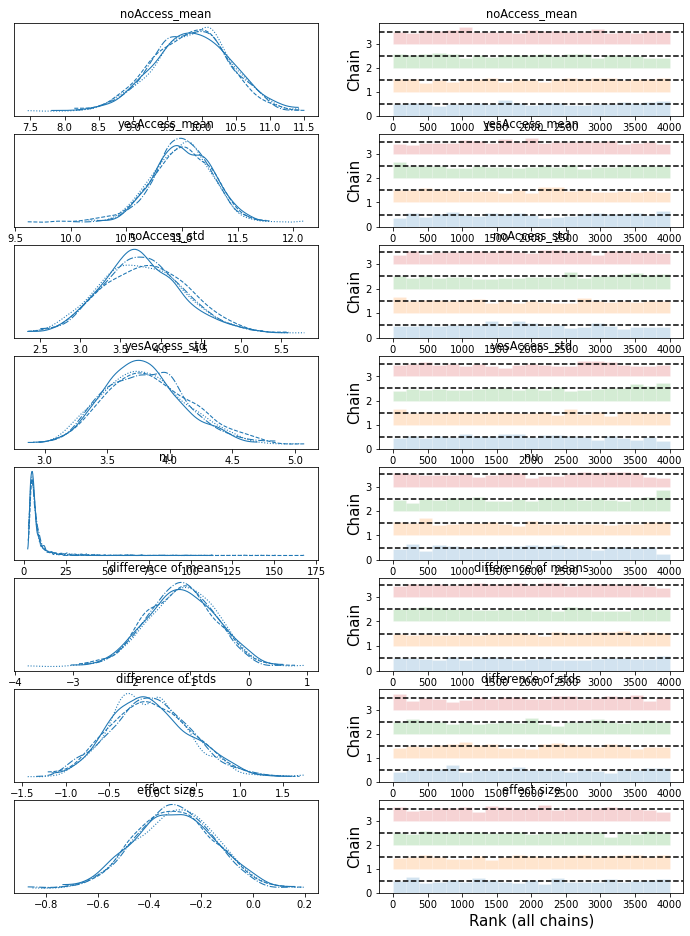

In [179]:
az.plot_trace(internet_trace, kind= 'rank_bars')

In [180]:
az.summary(internet_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
noAccess_mean,9.847,0.550,8.796,10.851,0.010,0.007,2913.0,2691.0,1.0
yesAccess_mean,11.001,0.263,10.498,11.453,0.006,0.004,2066.0,2044.0,1.0
noAccess_std,3.788,0.513,2.841,4.752,0.013,0.009,1663.0,2099.0,1.0
yesAccess_std,3.806,0.330,3.219,4.443,0.009,0.007,1280.0,1657.0,1.0
nu,8.366,9.779,2.500,19.229,0.317,0.224,1211.0,997.0,1.0
difference of means,-1.154,0.584,-2.191,-0.048,0.010,0.007,3575.0,2582.0,1.0
difference of stds,-0.018,0.465,-0.881,0.834,0.007,0.007,3995.0,2896.0,1.0
effect size,-0.305,0.153,-0.595,-0.030,0.003,0.002,3579.0,2502.0,1.0


array([<Axes: title={'center': 'difference of means'}>,
       <Axes: title={'center': 'difference of stds'}>,
       <Axes: title={'center': 'effect size'}>], dtype=object)

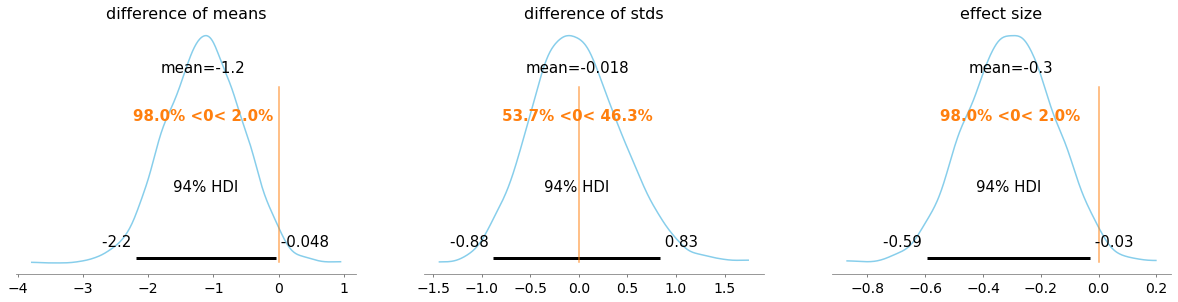

In [181]:
az.plot_posterior(
    internet_trace,
    var_names=["difference of means", "difference of stds", "effect size"],
    ref_val=0,
    color="#87ceeb")

# Trying out Bambi

In [182]:
dummies_2 = pd.get_dummies(clean, dtype=int)
dummies_2.head()

,student_id,age,class_failures,school_support,family_support,extra_paid_classes,activities,nursery_school,higher_ed,internet_access,...,guardian_mother,guardian_other,travel_time_15 to 30 min.,travel_time_30 min. to 1 hour,travel_time_<15 min.,travel_time_>1 hour,study_time_2 to 5 hours,study_time_5 to 10 hours,study_time_<2 hours,study_time_>10 hours
0,1,18,0,1,0,0,0,1,1,0,...,1,0,1,0,0,0,1,0,0,0
1,2,17,0,0,1,0,0,0,1,1,...,0,0,0,0,1,0,1,0,0,0
2,3,15,3,1,0,1,0,1,1,1,...,1,0,0,0,1,0,1,0,0,0
3,4,15,0,0,1,1,1,1,1,1,...,1,0,0,0,1,0,0,1,0,0
4,5,16,0,0,1,1,0,1,1,0,...,0,0,0,0,1,0,1,0,0,0


Getting rid of odd characters in the column names

In [210]:
dummies_2.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
dummies_2.rename(columns=lambda x: x.replace('(', ''), inplace=True)
dummies_2.rename(columns=lambda x: x.replace(')', ''), inplace=True)
dummies_2.rename(columns=lambda x: x.replace('<', 'less_'), inplace=True)
dummies_2.rename(columns=lambda x: x.replace('>', 'greater_'), inplace=True)

In [211]:
dummies_2.head()

,student_id,age,class_failures,school_support,family_support,extra_paid_classes,activities,nursery_school,higher_ed,internet_access,...,guardian_mother,guardian_other,travel_time_15_to_30_min.,travel_time_30_min._to_1_hour,travel_time_less_15_min.,travel_time_greater_1_hour,study_time_2_to_5_hours,study_time_5_to_10_hours,study_time_less_2_hours,study_time_greater_10_hours
0,1,18,0,1,0,0,0,1,1,0,...,1,0,1,0,0,0,1,0,0,0
1,2,17,0,0,1,0,0,0,1,1,...,0,0,0,0,1,0,1,0,0,0
2,3,15,3,1,0,1,0,1,1,1,...,1,0,0,0,1,0,1,0,0,0
3,4,15,0,0,1,1,1,1,1,1,...,1,0,0,0,1,0,0,1,0,0
4,5,16,0,0,1,1,0,1,1,0,...,0,0,0,0,1,0,1,0,0,0


In [212]:
dummies_2.columns

Index(['student_id', 'age', 'class_failures', 'school_support',
       'family_support', 'extra_paid_classes', 'activities', 'nursery_school',
       'higher_ed', 'internet_access', 'romantic_relationship',
       'family_relationship', 'free_time', 'social', 'weekday_alcohol',
       'weekend_alcohol', 'health', 'absences', 'grade_1', 'grade_2',
       'final_grade', 'school_GP', 'school_MS', 'sex_F', 'sex_M',
       'address_type_Rural', 'address_type_Urban',
       'family_size_Greater_than_3', 'family_size_Less_than_or_equal_to_3',
       'parent_status_Apart', 'parent_status_Living_together',
       'mother_education_5th_to_9th_grade',
       'mother_education_higher_education', 'mother_education_none',
       'mother_education_primary_education_4th_grade',
       'mother_education_secondary_education',
       'father_education_5th_to_9th_grade',
       'father_education_higher_education', 'father_education_none',
       'father_education_primary_education_4th_grade',
       'fath

In [214]:
predictors = dummies_2.drop('final_grade',axis=1)

Joining the column names in one long string, separated by a + to use bambi

In [215]:
result = '+'.join(predictors.columns)
result

'student_id+age+class_failures+school_support+family_support+extra_paid_classes+activities+nursery_school+higher_ed+internet_access+romantic_relationship+family_relationship+free_time+social+weekday_alcohol+weekend_alcohol+health+absences+grade_1+grade_2+school_GP+school_MS+sex_F+sex_M+address_type_Rural+address_type_Urban+family_size_Greater_than_3+family_size_Less_than_or_equal_to_3+parent_status_Apart+parent_status_Living_together+mother_education_5th_to_9th_grade+mother_education_higher_education+mother_education_none+mother_education_primary_education_4th_grade+mother_education_secondary_education+father_education_5th_to_9th_grade+father_education_higher_education+father_education_none+father_education_primary_education_4th_grade+father_education_secondary_education+mother_job_at_home+mother_job_health+mother_job_other+mother_job_services+mother_job_teacher+father_job_at_home+father_job_health+father_job_other+father_job_services+father_job_teacher+school_choice_reason_course+scho

In [218]:
prelim_model = bm.Model('final_grade ~ ' + result,
                        data = dummies_2,
                        family='gaussian')

prelim_model

       Formula: final_grade ~ student_id+age+class_failures+school_support+family_support+extra_paid_classes+activities+nursery_school+higher_ed+internet_access+romantic_relationship+family_relationship+free_time+social+weekday_alcohol+weekend_alcohol+health+absences+grade_1+grade_2+school_GP+school_MS+sex_F+sex_M+address_type_Rural+address_type_Urban+family_size_Greater_than_3+family_size_Less_than_or_equal_to_3+parent_status_Apart+parent_status_Living_together+mother_education_5th_to_9th_grade+mother_education_higher_education+mother_education_none+mother_education_primary_education_4th_grade+mother_education_secondary_education+father_education_5th_to_9th_grade+father_education_higher_education+father_education_none+father_education_primary_education_4th_grade+father_education_secondary_education+mother_job_at_home+mother_job_health+mother_job_other+mother_job_services+mother_job_teacher+father_job_at_home+father_job_health+father_job_other+father_job_services+father_job_teacher+sch

In [219]:
prelim_results = prelim_model.fit(random_seed=1738)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [final_grade_sigma, Intercept, student_id, age, class_failures, school_support, family_support, extra_paid_classes, activities, nursery_school, higher_ed, internet_access, romantic_relationship, family_relationship, free_time, social, weekday_alcohol, weekend_alcohol, health, absences, grade_1, grade_2, school_GP, school_MS, sex_F, sex_M, address_type_Rural, address_type_Urban, family_size_Greater_than_3, family_size_Less_than_or_equal_to_3, parent_status_Apart, parent_status_Living_together, mother_education_5th_to_9th_grade, mother_education_higher_education, mother_education_none, mother_education_primary_education_4th_grade, mother_education_secondary_education, father_education_5th_to_9th_grade, father_education_higher_education, father_education_none, father_education_primary_education_4th_grade, father_education_secondary_education, mother_job_at_home, mot

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1312 seconds.


/Users/stephenkullman/anaconda3/envs/bayesml/lib/python3.11/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (67), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'student_id'}>,
        <Axes: title={'center': 'student_id'}>],
       [<Axes: title={'center': 'age'}>, <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'class_failures'}>,
        <Axes: title={'center': 'class_failures'}>],
       [<Axes: title={'center': 'school_support'}>,
        <Axes: title={'center': 'school_support'}>],
       [<Axes: title={'center': 'family_support'}>,
        <Axes: title={'center': 'family_support'}>],
       [<Axes: title={'center': 'extra_paid_classes'}>,
        <Axes: title={'center': 'extra_paid_classes'}>],
       [<Axes: title={'center': 'activities'}>,
        <Axes: title={'center': 'activities'}>],
       [<Axes: title={'center': 'nursery_school'}>,
        <Axes: title={'center': 'nursery_school'}>],
       [<Axes: title={'center': 'higher_ed'}>,
        <Axes: title={'center': 'higher_ed'}>],
       [

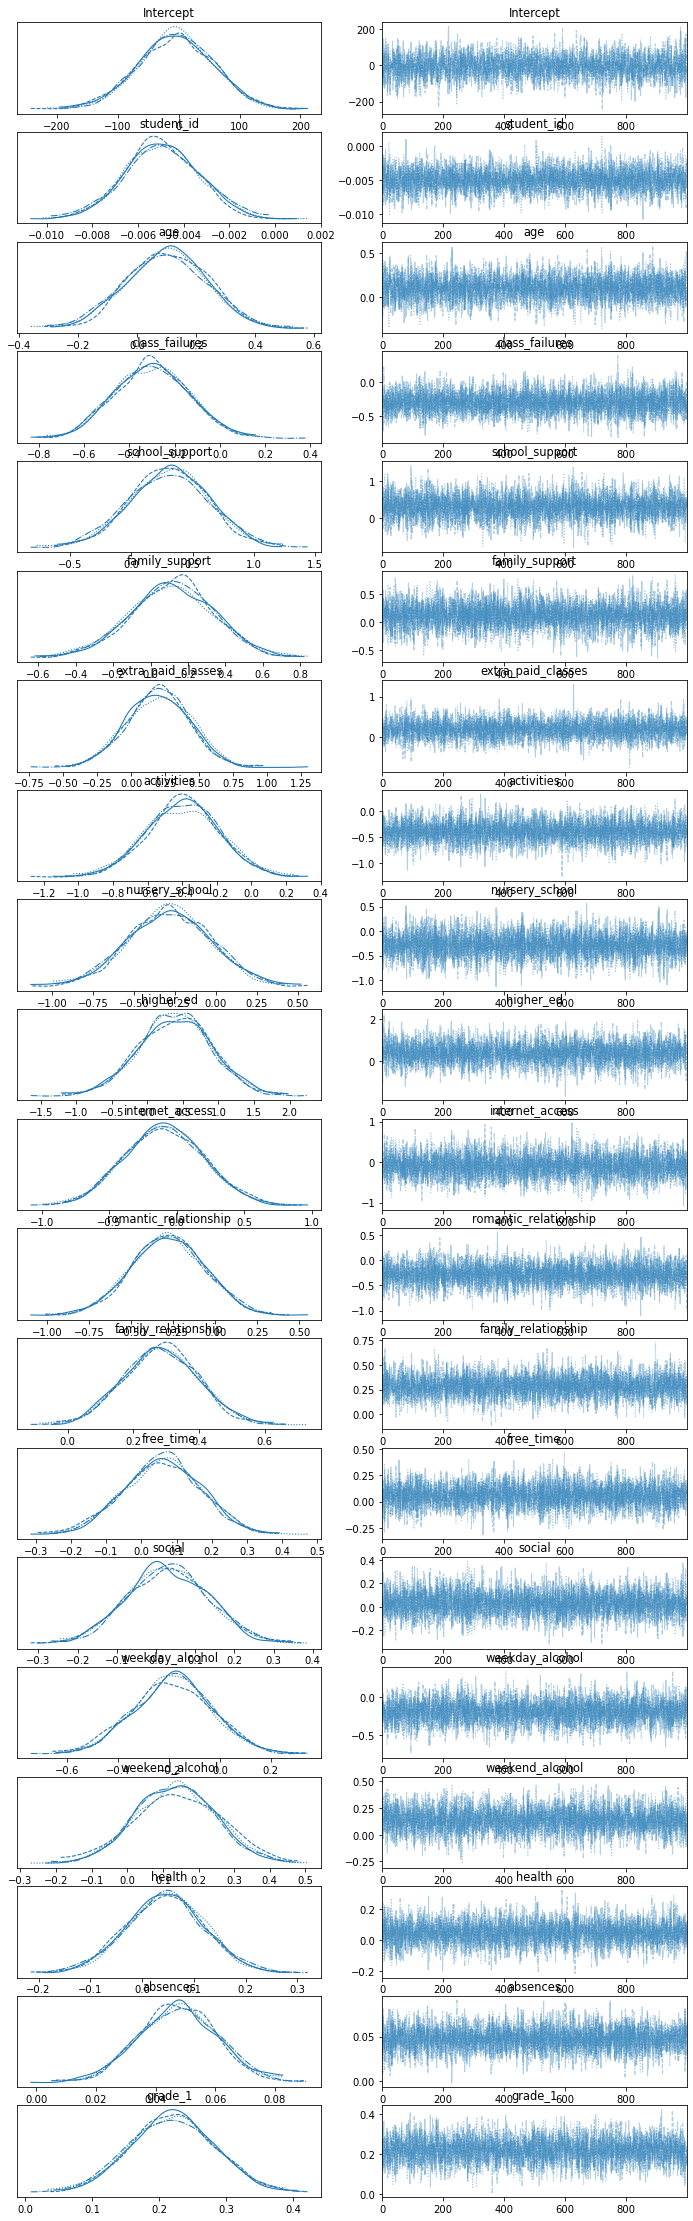

In [221]:
az.plot_trace(prelim_results)

In [222]:
az.summary(prelim_results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-5.280,62.299,-119.892,112.569,1.040,0.975,3591.0,3037.0,1.0
student_id,-0.005,0.002,-0.008,-0.002,0.000,0.000,4968.0,3332.0,1.0
age,0.101,0.138,-0.150,0.360,0.002,0.002,4512.0,3103.0,1.0
class_failures,-0.301,0.162,-0.600,0.001,0.002,0.002,5865.0,3192.0,1.0
school_support,0.308,0.326,-0.329,0.908,0.004,0.004,5419.0,2671.0,1.0
...,...,...,...,...,...,...,...,...,...
study_time_2_to_5_hours,0.146,14.197,-26.303,26.203,0.289,0.237,2413.0,2058.0,1.0
study_time_5_to_10_hours,0.384,14.198,-25.332,27.172,0.289,0.237,2416.0,2089.0,1.0
study_time_less_2_hours,0.259,14.202,-27.264,25.185,0.288,0.237,2420.0,2037.0,1.0
study_time_greater_10_hours,-0.478,14.213,-27.623,25.043,0.289,0.237,2413.0,2056.0,1.0
